
--- RMSE vs Trees ---
100 trees → RMSE = 21.141
200 trees → RMSE = 21.101
300 trees → RMSE = 21.077
400 trees → RMSE = 21.050
500 trees → RMSE = 21.067
600 trees → RMSE = 21.039
700 trees → RMSE = 21.039


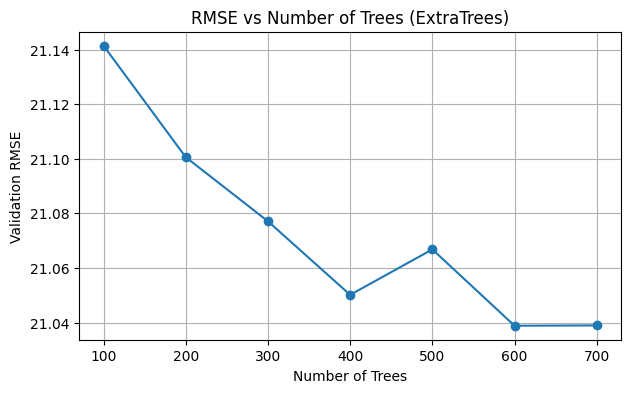


Best trees: 600

--- FINAL TEST METRICS ---
RMSE: 20.973
R²: 0.9505


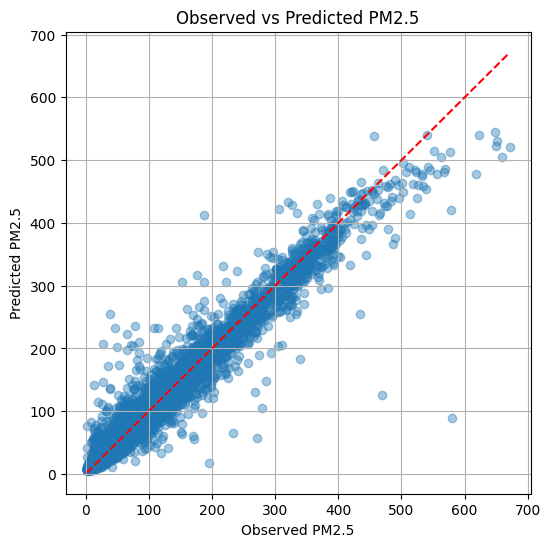


Next 1-hour PM2.5 prediction: 10.308


In [1]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

CSV_PATH = r"C:\Users\khush\OneDrive\Documents\data.csv"
LAGS = 48
TEST_RATIO = 0.2
VAL_RATIO = 0.1


df = pd.read_csv(CSV_PATH)
df["pm2.5"] = pd.to_numeric(df["pm2.5"], errors="coerce")
df = df.dropna(subset=["pm2.5"])

df["datetime"] = pd.to_datetime(df[["year","month","day","hour"]])
df = df.sort_values("datetime").set_index("datetime")
df["weekday"] = df.index.weekday

if "cbwd" in df.columns:
    df = pd.get_dummies(df, columns=["cbwd"], drop_first=True)


for i in range(1, LAGS+1):
    df[f"lag_{i}"] = df["pm2.5"].shift(i)

df["hour_sin"] = np.sin(2*np.pi*df.index.hour/24)
df["hour_cos"] = np.cos(2*np.pi*df.index.hour/24)

df = df.dropna()

X = df.drop(columns=["pm2.5"])
y = df["pm2.5"]


N = len(df)
test_idx = int(N * (1 - TEST_RATIO))
val_idx  = int(test_idx * (1 - VAL_RATIO))

X_train = X.iloc[:val_idx]
y_train = y.iloc[:val_idx]

X_val = X.iloc[val_idx:test_idx]
y_val = y.iloc[val_idx:test_idx]

X_test = X.iloc[test_idx:]
y_test = y.iloc[test_idx:]


trees = range(100, 701, 100)
rmse_list = []

print("\n--- RMSE vs Trees ---")

for n in trees:
    model = ExtraTreesRegressor(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    rmse_list.append(rmse)
    print(f"{n} trees → RMSE = {rmse:.3f}")

plt.figure(figsize=(7,4))
plt.plot(trees, rmse_list, marker="o")
plt.xlabel("Number of Trees")
plt.ylabel("Validation RMSE")
plt.title("RMSE vs Number of Trees (ExtraTrees)")
plt.grid()
plt.show()

best_trees = trees[np.argmin(rmse_list)]
print("\nBest trees:", best_trees)


model = ExtraTreesRegressor(
    n_estimators=best_trees,
    random_state=42,
    n_jobs=-1
)
model.fit(X.iloc[:test_idx], y.iloc[:test_idx])


y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- FINAL TEST METRICS ---")
print("RMSE:", round(rmse,3))
print("R²:", round(r2,4))


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("Observed PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Observed vs Predicted PM2.5")
plt.grid()
plt.show()


next_hour_pred = model.predict(X.iloc[-1:].values)[0]
print("\nNext 1-hour PM2.5 prediction:", round(next_hour_pred, 3))


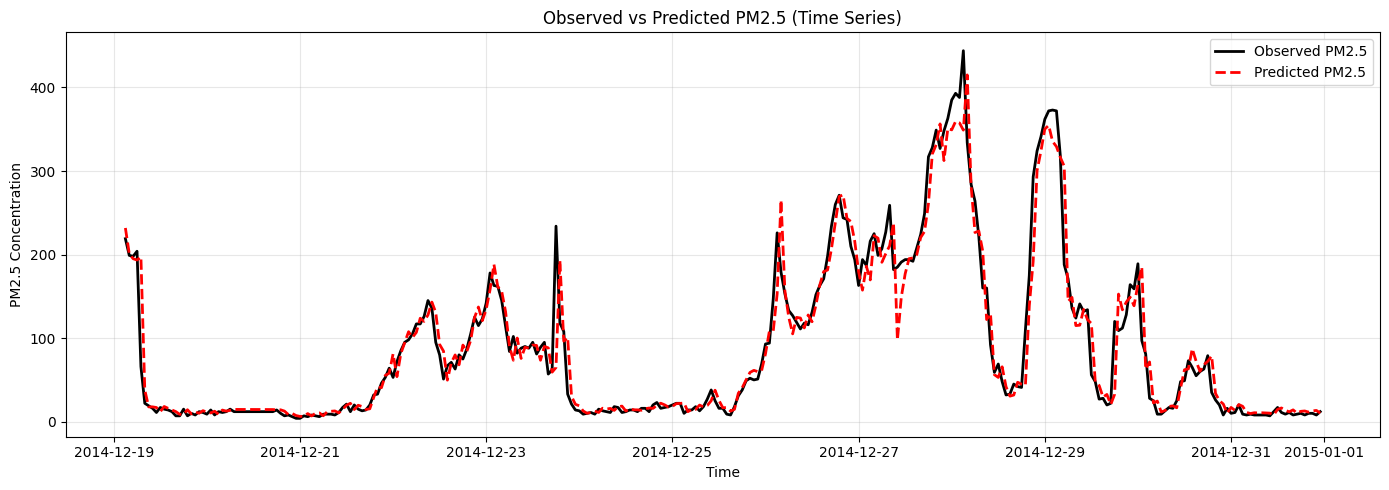

In [2]:

N_PLOT = 300   # you can change to 200, 500, etc.

time_index = y_test.index[-N_PLOT:]
actual = y_test.values[-N_PLOT:]
predicted = y_pred[-N_PLOT:]

plt.figure(figsize=(14,5))

plt.plot(time_index, actual,
         label="Observed PM2.5",
         color="black",
         linewidth=2)

plt.plot(time_index, predicted,
         label="Predicted PM2.5",
         color="red",
         linestyle="--",
         linewidth=2)

plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.title("Observed vs Predicted PM2.5 (Time Series)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
